Image chargée avec succès !
Dimensions de l'image : (1024, 1280)
Type de données : uint16


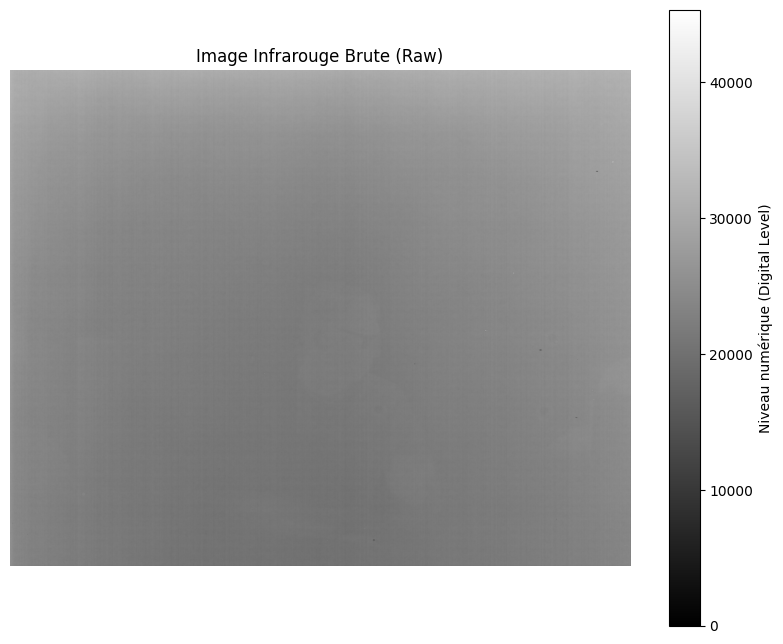

Valeur min : 0
Valeur max : 45332
Moyenne   : 24038.26


In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Définition du chemin du fichier
# Note : On utilise r"..." pour que Python gère correctement les antislashes Windows
file_path = r"C:\Users\prich\Documents\Lynred\im_ir\im_ir_00000001.tif"

# 2. Chargement de l'image
# IMPORTANT : Le flag 'cv2.IMREAD_UNCHANGED' ou -1 est crucial.
# Sans lui, OpenCV risque de convertir l'image brute 16 bits en 8 bits, 
# ce qui écraserait la dynamique nécessaire pour la NUC et le BPR.
img_raw = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

# 3. Vérification du chargement
if img_raw is None:
    print(f"Erreur : Impossible de charger l'image à l'emplacement : {file_path}")
    print("Vérifiez que le chemin est correct et que le fichier existe.")
else:
    print("Image chargée avec succès !")
    print(f"Dimensions de l'image : {img_raw.shape}")
    print(f"Type de données : {img_raw.dtype}") 
    # Vous devriez voir 'uint16' ici, confirmant que c'est bien l'image brute.

    # 4. Affichage simple (Visualisation brute)
    # Les images brutes sont souvent très sombres ou peu contrastées avant traitement.
    # Matplotlib gère automatiquement le min/max pour l'affichage, ce qui aide à voir quelque chose.
    plt.figure(figsize=(10, 8))
    plt.imshow(img_raw, cmap='gray')
    plt.title("Image Infrarouge Brute (Raw)")
    plt.colorbar(label="Niveau numérique (Digital Level)")
    plt.axis('off') # Enlever les axes pour plus de clarté
    plt.show()

    # Statistiques simples pour comprendre la dynamique du capteur
    print(f"Valeur min : {np.min(img_raw)}")
    print(f"Valeur max : {np.max(img_raw)}")
    print(f"Moyenne   : {np.mean(img_raw):.2f}")

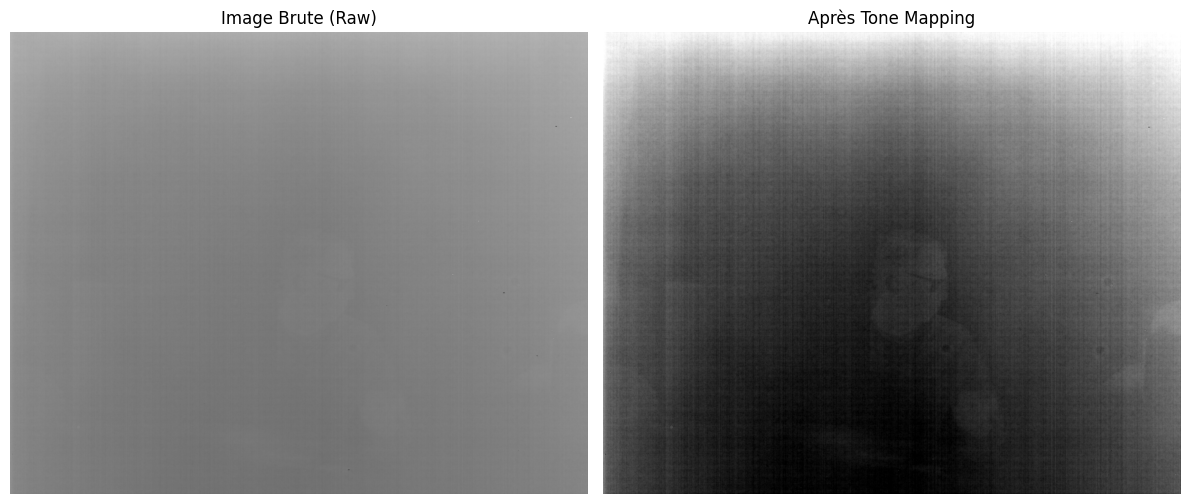

In [110]:
def tone_mapping(img_raw, percentile_low=1, percentile_high=99):
    """
    Applique un tone mapping linéaire simple.
    
    Paramètres:
    -----------
    img_raw : ndarray
        Image brute en uint16
    percentile_low : float
        Percentile inférieur pour le clipping (0-100)
    percentile_high : float
        Percentile supérieur pour le clipping (0-100)
    
    Retourne:
    ---------
    img_mapped : ndarray
        Image mappée en uint8 (0-255)
    """
    # Clipping sur les percentiles
    vmin = np.percentile(img_raw, percentile_low)
    vmax = np.percentile(img_raw, percentile_high)
    img_clipped = np.clip(img_raw, vmin, vmax)
    
    # Normalisation et conversion en uint8
    img_output = ((img_clipped - vmin) / (vmax - vmin) * 255).astype(np.uint8)
    
    return img_output


# Utilisation
if img_raw is not None:
    img_tone = tone_mapping(img_raw)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].imshow(img_raw, cmap='gray')
    axes[0].set_title('Image Brute (Raw)')
    axes[0].axis('off')
    
    axes[1].imshow(img_tone, cmap='gray')
    axes[1].set_title('Après Tone Mapping')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

Nombre d'images de référence chargées : 50


Text(0.5, 1.0, "Image après Correction d'Offset et tone mapping")

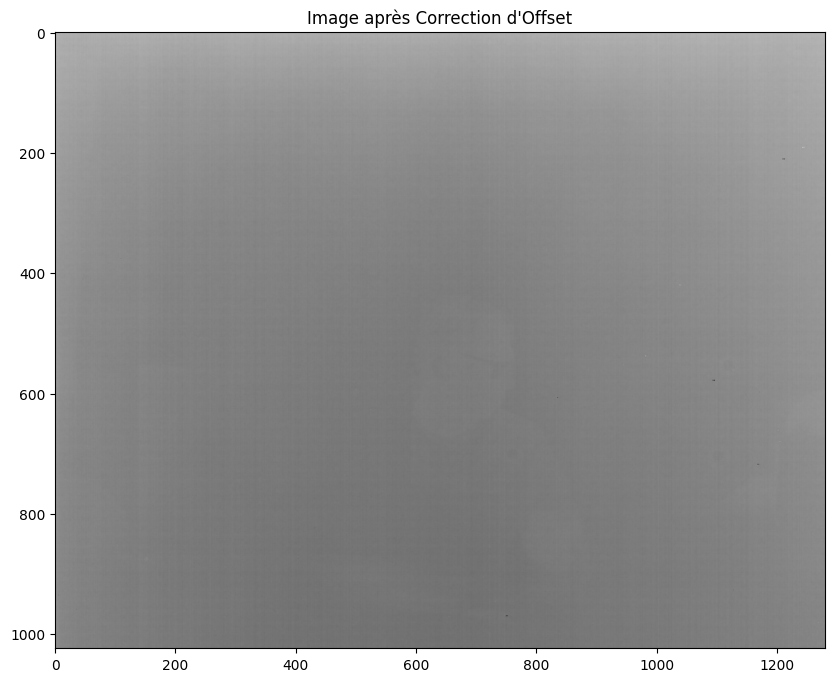

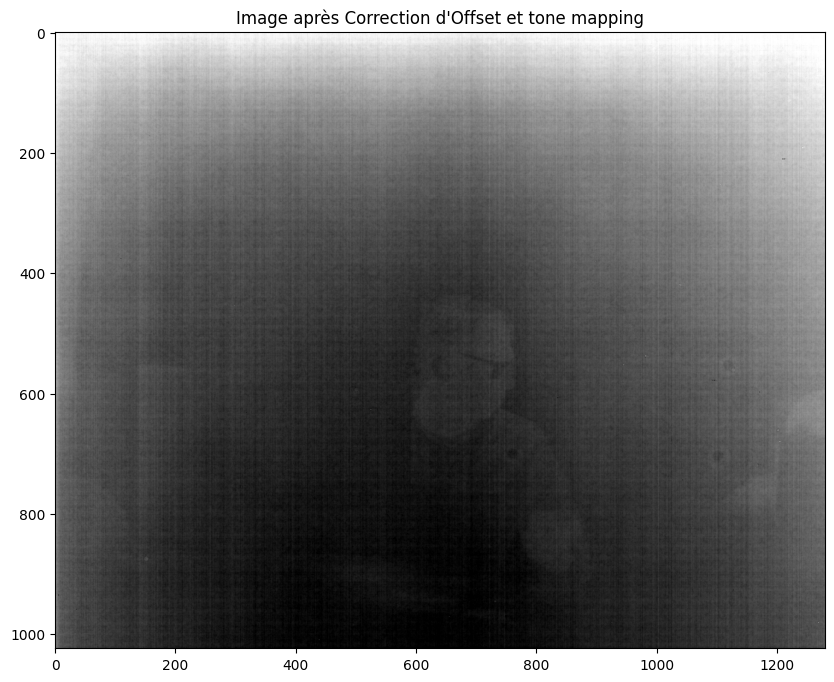

In [ ]:
#Traitement NUC avec correction d'offset

# Charger TOUTES les images du dossier bb1
bb1_folder = r"C:\Users\prich\Documents\Lynred\bb1"
offset_images = []

for filename in sorted(os.listdir(bb1_folder)):
    if filename.endswith('.tif'):
        img_path = os.path.join(bb1_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is not None:
            offset_images.append(img)

print(f"Nombre d'images de référence chargées : {len(offset_images)}")

def compute_offset_map(ref_images):
    """
    Calcule la carte d'offset à partir d'une série d'images de référence (corps noir).
    
    Args:
        ref_images (list ou np.array): Liste d'images (2D) ou tableau 3D (N, H, W)
                                       d'une scène uniforme.
    
    Returns:
        offset_map (np.array): La matrice des offsets à soustraire (type float64).
    """
    # 1. Moyennage temporel pour réduire le bruit (recommandé slide 30)
    # On transforme la liste en tableau numpy si nécessaire
    stack = np.array(ref_images, dtype=np.float64)
    
    # Moyenne pixel par pixel sur l'axe temporel (axis 0)
    # Images_T1 dans la formule
    avg_ref_img = np.mean(stack, axis=0)
    
    # 2. Calcul de la moyenne spatiale de l'image de référence
    # <Images_T1> dans la formule
    global_mean = np.mean(avg_ref_img)
    
    # 3. Calcul de la carte d'offset
    # Formule : Offset = Images_T1 - <Images_T1>
    offset_map = avg_ref_img - global_mean
    
    return offset_map

def apply_offset_correction(raw_img, gain_map):
    """
    Applique la correction d'offset sur une image brute.
    
    Args:
        raw_img (np.array): Image brute (uint14/16).
        offset_map (np.array): Carte d'offset calculée précédemment.
        
    Returns:
        corrected_img (np.array): Image corrigée (float64).
    """
    # Conversion en float pour éviter les erreurs de signe (underflow)
    img_float = raw_img.astype(np.float64)
    
    # Application de la formule : pixel_corrige = pixel_brut - offset
    corrected_img = img_float - offset_map
    
    return corrected_img

# Maintenant calcul de l'offset map avec plusieurs images
offset_map = compute_offset_map(offset_images)
corrected_img = apply_offset_correction(img_raw, offset_map)

# Affichage de l'image corrigée
plt.figure(figsize=(10, 8))
plt.imshow(corrected_img, cmap='gray')
plt.title("Image après Correction d'Offset")

img_tone_offset = tone_mapping(corrected_img)
plt.figure(figsize=(10, 8))
plt.imshow(img_tone_offset, cmap='gray')
plt.title("Image après Correction d'Offset et tone mapping")

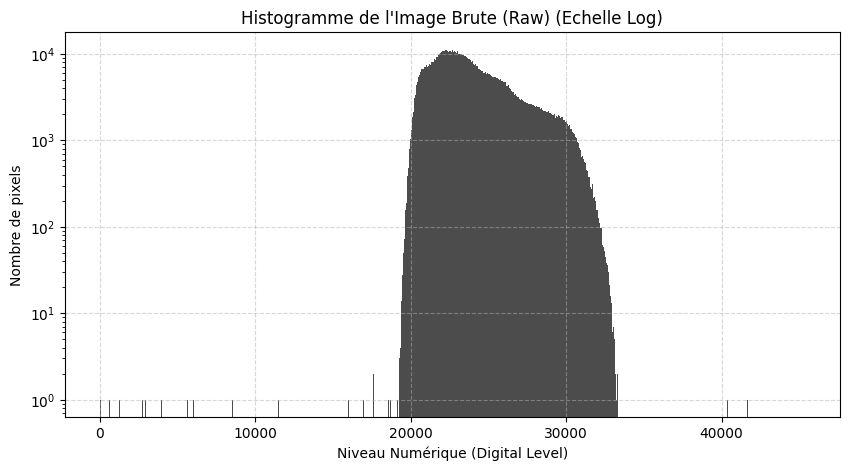

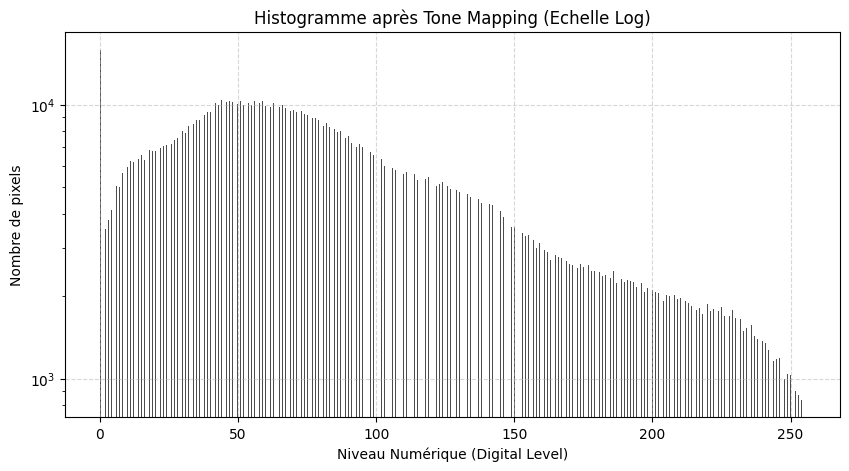

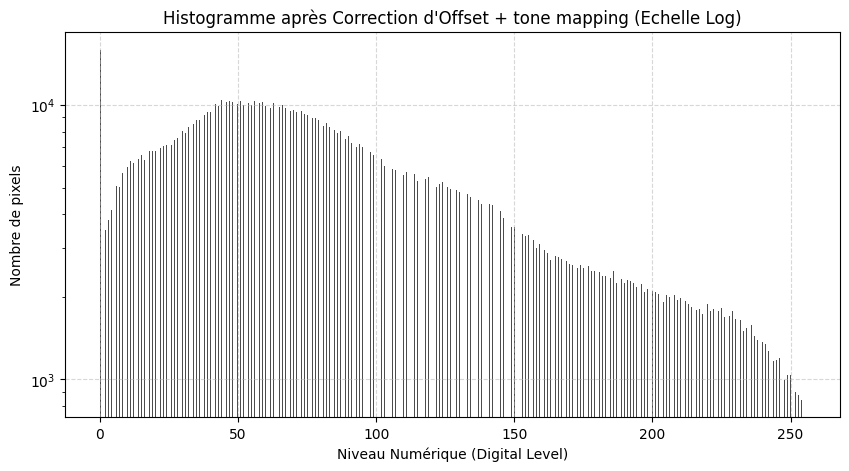

In [112]:
def plot_histogram(image, title="Histogramme", bins=1024, log_scale=False):
    """
    Affiche l'histogramme des niveaux de gris d'une image.
    
    Args:
        image (np.array): L'image (2D) dont on veut l'histogramme.
        title (str): Titre du graphique.
        bins (int): Nombre de barres dans l'histogramme. 
                    Pour du 16 bits, mettez une valeur élevée (ex: 1024 ou 'auto').
        log_scale (bool): Si True, passe l'axe Y en échelle logarithmique 
                          (utile pour voir les pixels rares comme les pixels défectueux).
    """
    # 1. Aplatir l'image en 1D (transforme la matrice en une longue liste de pixels)
    data = image.ravel()
    
    plt.figure(figsize=(10, 5))
    
    # 2. Création de l'histogramme
    # color='black' rappelle qu'on travaille en niveaux de gris
    # alpha=0.7 permet de voir la grille derrière
    plt.hist(data, bins=bins, color='black', alpha=0.7)
    
    # 3. Configuration de l'échelle logarithmique (optionnel mais recommandé en IR)
    if log_scale:
        plt.yscale('log')
        title += " (Echelle Log)"
    
    plt.title(title)
    plt.xlabel("Niveau Numérique (Digital Level)")
    plt.ylabel("Nombre de pixels")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Affichage des histogrammes
plot_histogram(img_raw, title="Histogramme de l'Image Brute (Raw)",log_scale=True)
plot_histogram(img_tone, title="Histogramme après Tone Mapping", log_scale=True)
plot_histogram(img_tone_offset, title="Histogramme après Correction d'Offset + tone mapping", log_scale=True)

In [113]:
# Charger les images du corps noir CHAUD (bb2 = T2)
bb2_folder = r"C:\Users\prich\Documents\Lynred\bb2"
bb2_images = []

for filename in sorted(os.listdir(bb2_folder)):
    if filename.endswith('.tif'):
        img_path = os.path.join(bb2_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is not None:
            bb2_images.append(img)

def compute_gain_map(ref_images_hot, offset_map):
    """
    Calcule la carte de gain pour NUC 2 points.
    
    Args:
        ref_images_hot: Images du corps noir à T2 (plus chaud que T1)
        offset_map: Carte d'offset calculée avec bb1 (T1)
    
    Returns:
        gain_map: Matrice des gains
    """
    # Moyenne des images chaudes
    stack_hot = np.array(ref_images_hot, dtype=np.float64)
    avg_ref_hot = np.mean(stack_hot, axis=0)
    
    # Correction d'offset sur l'image chaude
    img_hot_corrected = avg_ref_hot - offset_map
    
    # Moyenne cible
    target_mean = np.mean(img_hot_corrected)
    
    # Carte de gain
    epsilon = 1e-6
    gain_map = target_mean / (img_hot_corrected + epsilon)
    
    return gain_map

# Calcul du gain avec bb2 (température chaude)
gain_map = compute_gain_map(bb2_images, offset_map)


def apply_gain(gain_map, img_raw):
 
    corrected_img = img_raw * gain_map
    return corrected_img



Text(0.5, 1.0, 'Image après Application du Gain et Tone Mapping')

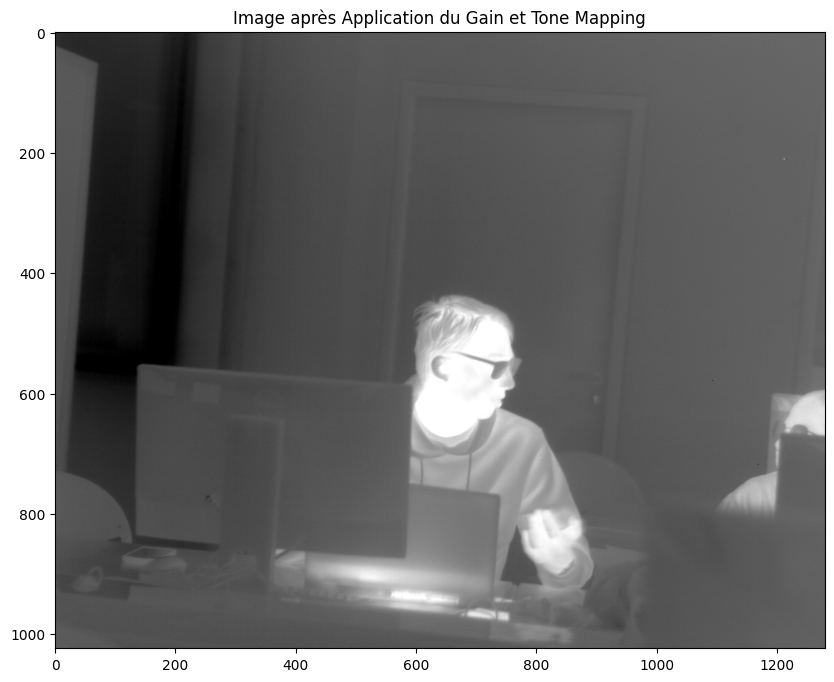

In [114]:
#image brute avec le gain
gain_map = compute_gain_map(bb2_images, offset_map)
img_gain = apply_gain(gain_map, img_raw)
img_gain_tone = tone_mapping(img_gain)
plt.figure(figsize=(10, 8))
plt.imshow(img_gain_tone, cmap='gray')
plt.title("Image après Application du Gain et Tone Mapping")

In [115]:

image_offset = apply_offset_correction(img_raw, offset_map)
image_offset_tone = tone_mapping(image_offset)

img_gain_offset = apply_gain(bb2_images, gain_map, image_offset)
img_gain_offset = tone_mapping(img_gain_offset)


fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(image_offset_tone, cmap='gray')
axes[0].set_title('Correction Offset + Tone Mapping')
axes[0].axis('off')

axes[1].imshow(img_gain_offset, cmap='gray')
axes[1].set_title('Correction Offset + Gain + Tone Mapping')
axes[1].axis('off')

plt.tight_layout()
plt.show()

TypeError: apply_gain() takes 2 positional arguments but 3 were given

Pixels défectueux détectés : 16 (0.001%)


(np.float64(-0.5), np.float64(1279.5), np.float64(1023.5), np.float64(-0.5))

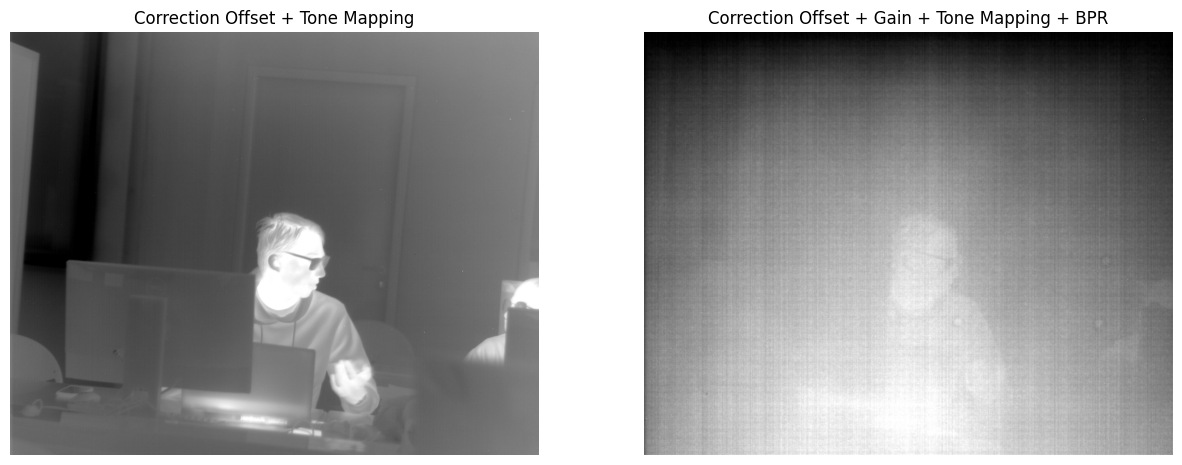

In [ ]:
#détection des pixels défectueux

def detect_bad_pixels(offset_map, gain_map=None, sigma_threshold=5.0):
    """
    Détecte les pixels défectueux en analysant les statistiques de l'offset (et du gain si dispo).
    
    Args:
        offset_map (np.array): Carte d'offset calculée.
        gain_map (np.array, optionnel): Carte de gain calculée.
        sigma_threshold (float): Nombre d'écarts-types pour considérer un pixel comme aberrant.
                                 (5.0 est standard : très sélectif).
    
    Returns:
        bad_pixel_mask (np.array): Masque binaire (1 = défectueux, 0 = bon).
    """
    rows, cols = offset_map.shape
    mask = np.zeros((rows, cols), dtype=np.uint8)
    
    # Calcul des statistiques sur l'offset
    mean_offset = np.mean(offset_map)
    std_offset = np.std(offset_map)
    
    # Détection des pixels aberrants (au-delà de sigma_threshold écarts-types)
    mask = np.abs(offset_map - mean_offset) > (sigma_threshold * std_offset)
    mask = mask.astype(np.uint8)
    
    percent_bad = (np.sum(mask) / mask.size) * 100
    print(f"Pixels défectueux détectés : {np.sum(mask)} ({percent_bad:.3f}%)")
    
    return mask

def replace_bad_pixels(image, mask):
    """
    Remplace les pixels marqués par le masque en utilisant une médiane locale.
    
    Args:
        image (np.array): Image à corriger (brute ou après NUC).
        mask (np.array): Masque des pixels défectueux (1 pour mauvais).
        
    Returns:
        corrected_img (np.array): Image avec les trous "bouchés".
    """
    # On s'assure que l'image est dans un format compatible (float32 recommandé pour le traitement)
    img_copy = image.astype(np.float32)
    
    # 1. On calcule une version "lissée" de toute l'image (filtre médian 3x3 ou 5x5)
    # Le filtre médian est excellent pour éliminer les pics de bruit (pixels morts)
    median_blurred = cv2.medianBlur(img_copy, 3)
    
    # 2. Fusion intelligente
    # Si le pixel est bon (mask=0), on garde l'original.
    # Si le pixel est mauvais (mask=1), on prend la valeur du filtre médian.
    corrected_img = np.where(mask == 1, median_blurred, img_copy)
    
    return corrected_img.astype(image.dtype)

detected_bad_pixel_mask = detect_bad_pixels(offset_map, sigma_threshold=5.0)
img_gain_offset_BPR = replace_bad_pixels(img_gain_offset, detected_bad_pixel_mask)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(image_offset_tone, cmap='gray')
axes[0].set_title('Correction Offset + Tone Mapping')
axes[0].axis('off')

axes[1].imshow(img_gain_offset_BPR, cmap='gray')
axes[1].set_title('Correction Offset + Gain + Tone Mapping + BPR')
axes[1].axis('off')

Pixels défectueux détectés : 16 (0.001%)


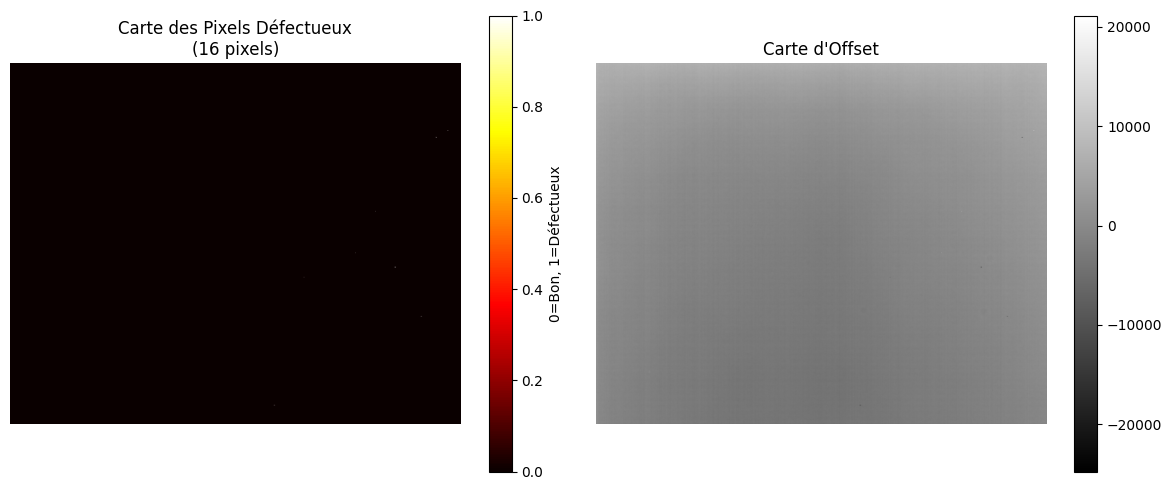

In [ ]:
detected_bad_pixel_mask = detect_bad_pixels(offset_map, sigma_threshold=5.0)

# Visualisation de la carte des pixels défectueux
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(detected_bad_pixel_mask, cmap='hot')
plt.title(f'Carte des Pixels Défectueux\n({np.sum(detected_bad_pixel_mask)} pixels)')
plt.colorbar(label='0=Bon, 1=Défectueux')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(offset_map, cmap='gray')
plt.title('Carte d\'Offset')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()




In [ ]:
#réduction du bruit temporel

def temporal_noise_reduction(current_img, accumulator, alpha=0.2):
    """
    Applique un filtre temporel récursif pour réduire le bruit.
    
    Args:
        current_img (np.array): L'image brute de la frame actuelle.
        accumulator (np.array): L'image filtrée de la frame précédente (mémoire).
                                Si None, initialise l'accumulateur avec l'image actuelle.
        alpha (float): Facteur de lissage (0.0 à 1.0). 
                       0.1 = fort lissage (bcp d'inertie).
                       0.8 = faible lissage (réactif).
                       
    Returns:
        new_accumulator (np.array): La nouvelle image filtrée (à stocker pour la prochaine boucle).
    """
    # Conversion en float pour la précision du calcul
    current_float = current_img.astype(np.float64)
    
    # Initialisation : si c'est la première image, on n'a pas d'historique
    if accumulator is None:
        return current_float
    
    # Application de la formule : Moyenne glissante
    # Out = (alpha * Input) + ((1 - alpha) * Prev_Out)
    new_accumulator = (alpha * current_float) + ((1.0 - alpha) * accumulator)
    
    return new_accumulator

list_images = sorted([f for f in os.listdir(r"C:\Users\prich\Documents\Lynred\im_ir") if f.endswith('.tif')])
accumulator = None

for filename in list_images:
    frame = cv2.imread(filename, -1)

    frame_corr = apply_offset_correction(frame, offset_map)
    frame_clean = replace_bad_pixels(frame_corr, detected_bad_pixel_mask)
    acc_image = temporal_noise_reduction(frame_clean, acc_image, alpha=0.3)
    cv2.imshow("IR Filtré", tone_mapping(acc_image))
    cv2.waitKey(10)

AttributeError: 'NoneType' object has no attribute 'astype'